# Sound speed as a source of modified gravity

In Horndeski theory, the dark energy sound speed is given by the basis functions $\alpha_M$, $\alpha_B$, $\alpha_K$ and $\alpha_T$. The term $\alpha_T$ is assumed to be zero. We can further assume $M_* = 1$, implying $\alpha_M = 0$. We obtain:

\begin{equation}
    \frac{\alpha_B'}{aH} = \frac{d\alpha_B}{d\ln a} = \left(\alpha_K + \frac{3}{2}\alpha_B^2 \right)c_s^2 + (\alpha_B - 2)\left(\frac{3}{2}(1 + w_t) + \frac{\alpha_B}{2} \right) + 3(1 + w_t).
\end{equation}

In terms of the $\mu-\Sigma$ parametrization, we find

\begin{equation}
    \mu = \Sigma = 1 + \frac{\alpha_B^2}{2c_s^2\left(\alpha_K + \frac{3}{2}\alpha_B^2\right)}
\end{equation}

Let's explore the solutions for $\alpha_B$ and $\mu$ assuming a k-essence parametrization

\begin{equation}
    \alpha_K = \frac{3\Omega_\mathrm{DE}(a)(1 + w_\mathrm{DE}(a))}{c_s^2}
\end{equation}

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt

## Engine

In [29]:
def rho_de(a, w0, wa, omega_de):
    return omega_de*a**(-3*(1 + w0 + wa))*np.exp(-3*wa*(1-a))

def rho_m(a, omega_m):
    return omega_m*a**-3

def rho_gamma(a, omega_r):
    return omega_r*a**-4

def w_tot(a, omega_m, omega_de, omega_r, w0, wa):
    w_de = w0 + wa*(1-a)
    rhog = rho_gamma(a, omega_r)
    rhom = rho_m(a, omega_m)
    rhode = rho_de(a, w0, wa, omega_de)
    rhotot = rhog + rhode + rhom
    return (rhog/3 + w_de*rhode)/rhotot, ((4/3)*rhog + rhom)/rhotot, rhode/rhotot # NOTE: `last_term` is (rho_no_de + P_no_de)/rho_tot

def deriv(loga, alpha_B, alpha_K_0=3, cs2=1, omega_m=0.3, w0=-1, wa=0):
    omega_r = 2.5e-5
    omega_de_0 = 1 - omega_m - omega_r
    a = np.exp(loga)
    wt, last_term, omega_de = w_tot(a, omega_m, omega_de_0, omega_r, w0, wa)
    w_de = w0 + wa*(1-a)
    alpha_K = alpha_K_0*omega_de*(1 + w_de)
    return cs2*(alpha_K + 1.5*alpha_B**2) + (alpha_B - 2)*(1.5*(1 + wt) + 0.5*alpha_B) + 3*last_term

def solve_alpha_B(cs2, omega_m, w0, w0pwa, alpha_B_init=0, method="euler"):
    wa = w0pwa - w0
    a_ini = 1e-5
    a_final = 1
    factor = 1
    if method == "scipy":
        return solve_ivp(deriv, (np.log(a_ini), np.log(a_final)), y0=(alpha_B_init,),  args=(factor, cs2, omega_m, w0, wa))
    elif method == "euler":
        N = 200 # Number of steps
        dloga = (np.log(a_final) - np.log(a_ini))/N
        result = np.zeros(N+1)
        mu = np.zeros(N+1)

        # Computing initial alpha_K
        omega_de_0 = 1 - omega_m - 2.5e-5
        w_de = w0 + wa*(1 - a_ini)
        rhode  = rho_de(a_ini, w0, wa, omega_de_0)
        rhotot = rho_m(a_ini, omega_m) + rho_gamma(a_ini, 2.5e-5) + rhode
        alpha_K = factor*(rhode/rhotot)*(1 + w_de)

        result[0] = alpha_B_init
        mu[0]     = 1 + alpha_B_init**2/2/(alpha_K + 1.5*alpha_B_init**2)/cs2
        loga = np.linspace(np.log(a_ini), np.log(a_final), N+1)
        for i in range(N):
            alpha_B = result[i]
            # if alpha_B**2 > 1e6*alpha_K:
            #     # JVR NOTE: for many cases, \alpha_B just blows up and in Python it becomes \inf.
            #     # For calculating \mu, this is not a problem, since \mu has a well-defined limit when \alpha_B -> \inf
            #     # In practice, I enforce this with the threshold defined above in the `if` statement
            #     # And then I just fill the rest of the arrays with the last values and break out of the integration loop
            #     for j in range(i, N+1):
            #         result[j] = result[i]
            #         mu[j]     = mu[i]
            #     break
            result[i+1] = alpha_B + deriv(loga[i], alpha_B, alpha_K, cs2, omega_m, w0, wa)*dloga
            
            a = np.exp(loga[i])
            rhode  = rho_de(a, w0, wa, omega_de_0)
            w_de = w0 + wa*(1 - a)
            rhotot = rho_m(a, omega_m) + rho_gamma(a, 2.5e-5) + rhode
            alpha_K = factor*(rhode/rhotot)*(1 + w_de)
            mu[i+1] = 1 + result[i+1]**2/2/(alpha_K + 1.5*result[i+1]**2)/cs2
        alpha_B = np.array(result)
        return loga*np.log10(np.e), alpha_B, mu
    else:
        raise Exception("Unknown method")
    
def study_alpha_B(alpha_K, cs2, omega_m, w0, wa):
    # Returns the derivative of alpha_B, evaluated in a grid of alpha_B, log(a)
    # Useful when assessing the stability of the system
    N_loga = 100 # Number of steps
    a_ini = 1e-5
    loga = np.linspace(np.log(a_ini), 0, N_loga)
    N_alpha_B = 100
    alpha_B = np.linspace(-10, 10, N_alpha_B)
    result = np.zeros((N_loga, N_alpha_B))
    for i in range(N_loga):
        for j in range(N_alpha_B):
            result[i, j] = deriv(loga[i], alpha_B[j], alpha_K, cs2, omega_m, w0, wa)
    return result, loga*np.log10(np.e), alpha_B

## One Cosmology

Text(0, 0.5, '$\\mu$')

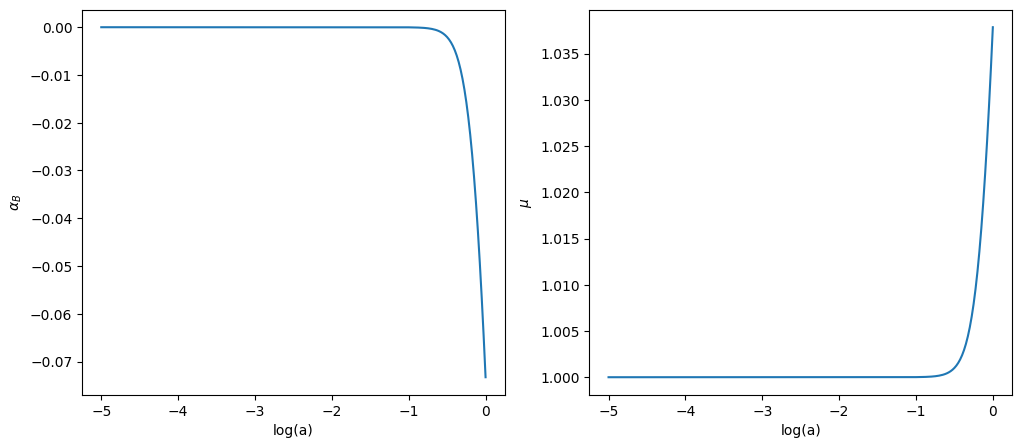

In [31]:
reference_cosmo = {
    "omega_m": 0.3,
    "w0": -0.9,
    "w0pwa": -1,
    "cs2": 1,
    "alpha_B_init": 0
}

log_a, alpha_B, mu = solve_alpha_B(**reference_cosmo, method="euler")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(log_a, alpha_B)
axs[0].set_xlabel("log(a)")
axs[0].set_ylabel("$\\alpha_B$")
axs[1].plot(log_a, mu)
axs[1].set_xlabel("log(a)")
axs[1].set_ylabel("$\\mu$")
# plt.savefig("plots/alpha_B_solution.pdf")

## Sampling across parameter space

### 1. Star Sampling

/tmp/ipykernel_16442/220406612.py:48: RuntimeWarning: invalid value encountered in scalar divide
  mu[0]     = 1 + alpha_B_init**2/2/(alpha_K + 1.5*alpha_B_init**2)/cs2
/tmp/ipykernel_16442/220406612.py:68: RuntimeWarning: invalid value encountered in scalar divide
  mu[i+1] = 1 + result[i+1]**2/2/(alpha_K + 1.5*result[i+1]**2)/cs2
/tmp/ipykernel_16442/220406612.py:48: RuntimeWarning: invalid value encountered in scalar divide
  mu[0]     = 1 + alpha_B_init**2/2/(alpha_K + 1.5*alpha_B_init**2)/cs2
/tmp/ipykernel_16442/220406612.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  mu[i+1] = 1 + result[i+1]**2/2/(alpha_K + 1.5*result[i+1]**2)/cs2
/tmp/ipykernel_16442/220406612.py:68: RuntimeWarning: invalid value encountered in scalar divide
  mu[i+1] = 1 + result[i+1]**2/2/(alpha_K + 1.5*result[i+1]**2)/cs2


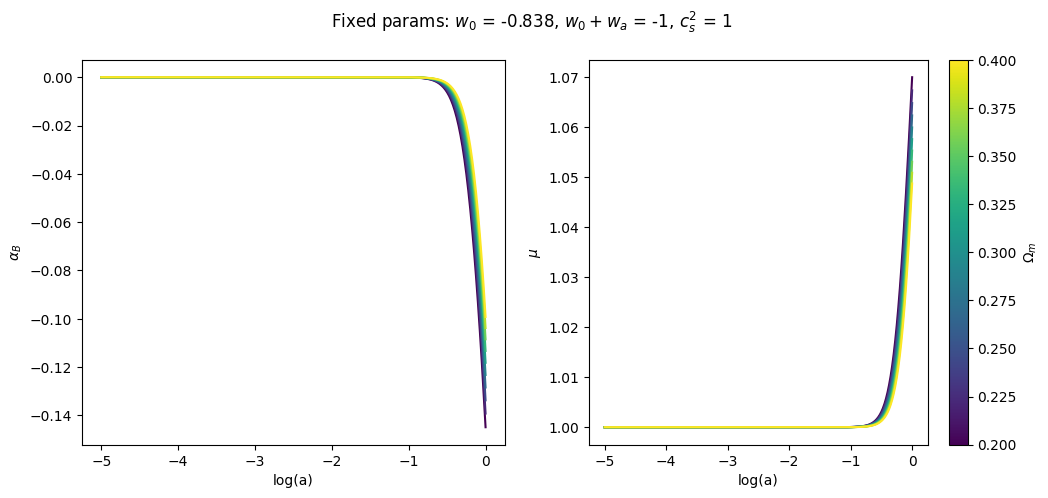

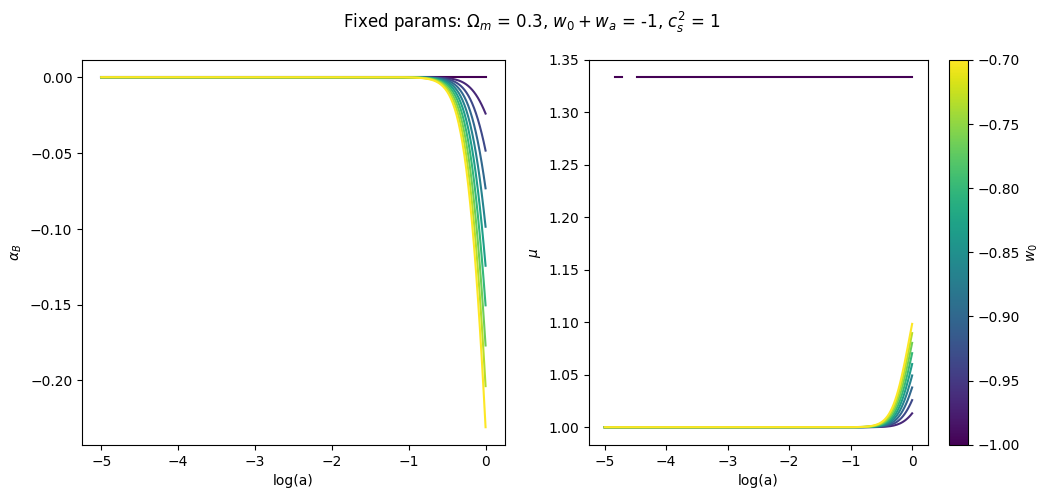

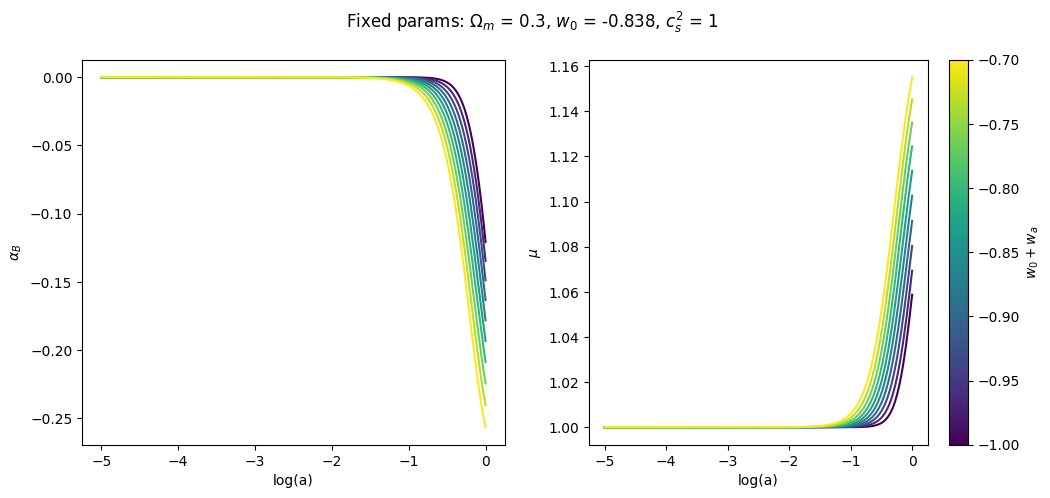

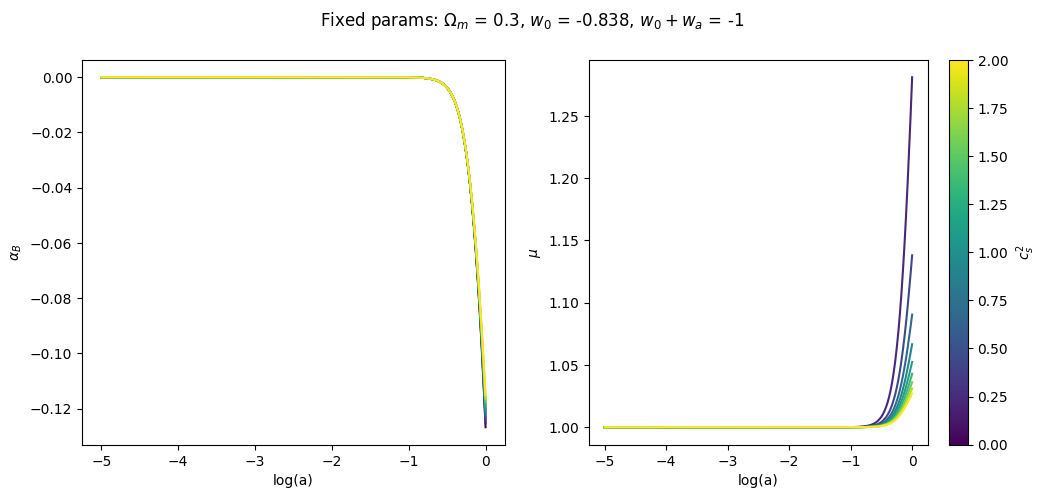

In [33]:
reference_cosmo = {
    "omega_m": 0.3,
    "w0": -0.838,
    "w0pwa": -1,
    "cs2": 1,
}

grids = {
    "omega_m": np.linspace(0.2, 0.4, 10),
    "w0"     : np.linspace(-1.0, -0.7, 10),
    "w0pwa"  : np.linspace(-1.0, -0.7, 10),
    "cs2"    : np.linspace(0, 2, 10),
    # "alpha_B_init": np.linspace(-1, 1, 10), # NOTE: solution converges to attractor quickly
}

param_name_latex = {
    "omega_m": "$\\Omega_m$",
    "w0"     : "$w_0$",
    "w0pwa"  : "$w_0 + w_a$",
    "cs2"    : "$c_s^2$",
}

cmap = plt.get_cmap('viridis')

for param_name in grids.keys():
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    params = reference_cosmo.copy()
    norm = mpl.colors.Normalize(vmin=grids[param_name][0], vmax=grids[param_name][-1])
    for param_value in grids[param_name]:
        params[param_name] = param_value
        loga, alpha_B, mu = solve_alpha_B(**params, method="euler")
        color = cmap(norm(param_value))
        axs[0].plot(loga, alpha_B, color=color)
        axs[1].plot(loga, mu, color=color)
    for ax in axs:
        ax.set_xlabel("log(a)")
    axs[0].set_ylabel("$\\alpha_B$")
    axs[1].set_ylabel("$\\mu$")
    
    del params[param_name]
    title = ", ".join([" = ".join((param_name_latex[name], f"{value}")) for (name, value) in params.items()])
    fig.suptitle(f"Fixed params: {title}")

    # Create a ScalarMappable for the colorbar (no data required)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # for colorbar compatibility

    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label(param_name_latex[param_name])
    plt.savefig(f"plots/alpha_B_solutions_quintalphaK/{param_name}_scan.pdf")

### 2. Random Sampling

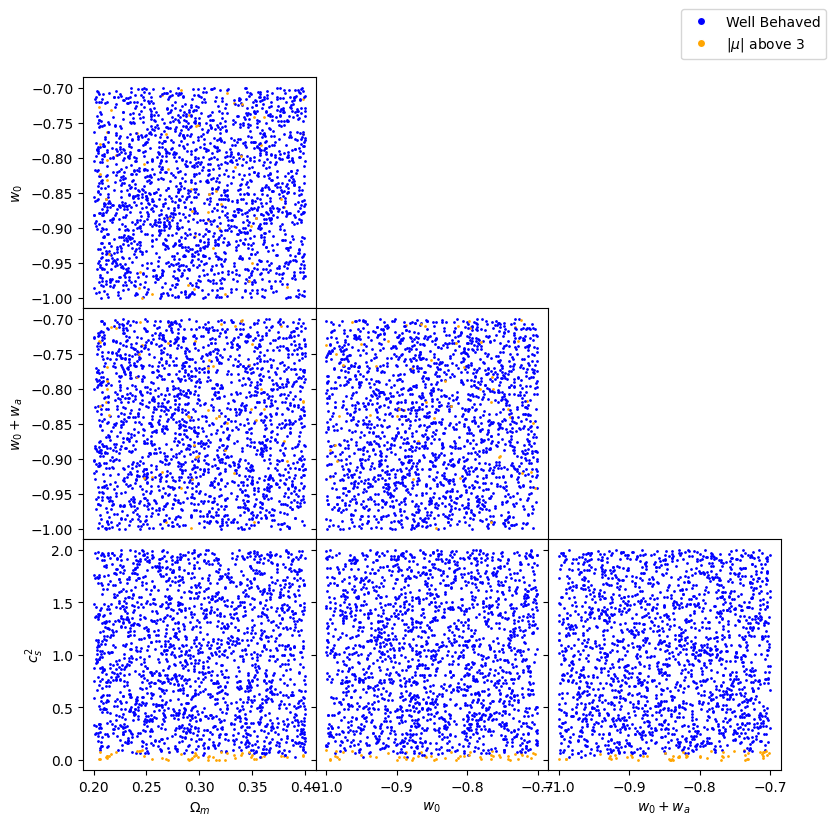

In [35]:
priors = {
    "omega_m": [0.2, 0.4],
    "w0"     : [-1.0, -0.7],
    "w0pwa"  : [-1.0, -0.7],
    "cs2"    : [0, 2],
}
priors_array = np.array(list(priors.values()))

alpha_B_threshold = 100
mu_threshold = 3

samples = []
for i in range(2_000):
    params = np.random.rand(len(priors))*(priors_array[:,1]-priors_array[:,0]) + priors_array[:,0]
    params_dict = dict(zip(priors.keys(), params))
    log_a, alpha_B, mu = solve_alpha_B(**params_dict, method="euler")
    # if np.any(alpha_B > alpha_B_threshold) or np.any(alpha_B < -alpha_B_threshold):
    #     samples.append((params, "red"))
    if np.any(mu > mu_threshold) or np.any(mu < -mu_threshold):
        samples.append((params, "orange"))
    else:
        samples.append((params, "blue"))


fig, axs = plt.subplots(len(params), len(params), figsize=(12, 12), gridspec_kw={"hspace": 0, "wspace": 0})
for row in range(len(params)):
    for col in range(len(params)):
        ax = axs[row, col]
        if row == len(params)-1: ax.set_xlabel(list(param_name_latex.values())[col])
        else: ax.set_xticklabels([])
        if col == 0:             ax.set_ylabel(list(param_name_latex.values())[row])
        else: ax.set_yticklabels([])
            
        if col >= row: ax.remove()
        for sample in samples:
            point, color = sample
            ax.scatter(point[col], point[row], color=color, s=1)

blue_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="blue", label="Well Behaved", )
orange_circle = mpl.lines.Line2D([], [], marker="o", color="w", markerfacecolor="orange", label=f"$|\\mu|$ above {mu_threshold}", )
fig.legend(handles=[blue_circle, orange_circle], bbox_to_anchor=(0.75, 0.75))

plt.savefig("plots/alpha_B_solutions_quintalphaK/alpha_B_samples.pdf", bbox_inches="tight")